In [77]:
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
from tqdm import tqdm
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import normalize, minmax_scale, scale, quantile_transform
import ipywidgets

plt.rcParams['figure.dpi'] = 100
# PATH_ROOT = Path('/content/drive/MyDrive/NMA-22/naturalistic_arm_movements_ecog')
PATH_ROOT = Path('/Volumes/GoogleDrive/My Drive/NMA-22/naturalistic_arm_movements_ecog')
PATH_CODE = PATH_ROOT.parent / 'Neuromatch_2022_EcoG_movements'
PATH_ROI = PATH_ROOT / "data" / "Naturalistic reach ECoG tfrs ROI"

In [6]:
data = pd.read_csv(PATH_ROI / "power-roi-all-patients-metadata.csv", index_col=0)
data.head()

,day,time,event_timestamp,mvmt,vid_name,event_frame_idx,false_pos,patient_id,I_over_C_ratio,r_wrist_x,...,l_wrist_y,audio_ratio,reach_duration,reach_r,reach_a,onset_velocity,other_reach_overlap,bimanual,other_lead_lag,patient_index
0,3,3520224,3520224,r_wrist,a0f66459_5_0500.avi,2206,0,a0f66459,0.029668,"[292.4933419228, 292.4933419228, 292.493341922...",...,"[211.6673732102, 211.6988453865, 211.667373210...",0.173995,29,56.068108,-152.360333,3.133708,0,0,NaN,0
1,3,3584342,3584342,r_wrist,a0f66459_5_0501.avi,536,0,a0f66459,0.005848,"[288.1831774712, 288.1836948395, 288.183694839...",...,"[208.3187561035, 208.3187561035, 208.318756103...",0.185332,29,120.020850,-103.292387,5.215469,0,0,NaN,0
2,3,28768352,28768352,r_wrist,a0f66459_5_0711.avi,73,0,a0f66459,0.039133,"[277.4298783541, 277.6194574833, 277.619457483...",...,"[221.6612606049, 221.6737040281, 221.794342160...",0.365911,41,37.482779,147.428994,3.061077,0,0,NaN,0
3,3,28853918,28853918,r_wrist,a0f66459_5_0711.avi,2640,0,a0f66459,0.030491,"[279.3920893669, 279.3920893669, 279.392089366...",...,"[222.3323924541, 222.3482117653, 222.35734725,...",0.501548,19,35.601992,-122.635080,2.163772,0,0,NaN,0
4,3,29639049,29639049,r_wrist,a0f66459_6_0000.avi,674,0,a0f66459,0.454378,"[252.2575044632, 252.2575044632, 252.257504463...",...,"[228.3691136539, 228.3421618044, 228.038380678...",0.238979,24,94.181709,-56.404814,5.021071,19,1,3.0,0


In [7]:
for side in ('r', 'l'):
    mask = data.mvmt == f"{side}_wrist"

    # Start from 0 time (sample 75)
    data.loc[mask, "event_x"] = data.loc[mask, f"{side}_wrist_x"]
    data.loc[mask, "event_y"] = data.loc[mask, f"{side}_wrist_y"]

data['event_x'] = data['event_x'].apply(lambda l: literal_eval(l)[:])
data['event_y'] = data['event_y'].apply(lambda l: literal_eval(l)[:])

In [87]:
from tsmoothie.smoother import LowessSmoother

dataset = np.empty((len(data), 2, 150))

for i, r in enumerate(data.iterrows()):
    dataset[i, 0, :] = r[1].event_x
    dataset[i, 1, :] = r[1].event_y

smoother = LowessSmoother(smooth_fraction=0.2, iterations=1)

# Subtract starting position
dataset -= dataset[:, :, :1]

for i in range(dataset.shape[0]):
    duration = data.loc[i].reach_duration
    
    
    sm = smoother.smooth(dataset[i, :,:])
    
    dataset[i, :,:] = sm.smooth_data
    
    # dataset[i, :,:] = dataset[i, :,:] / np.max(np.abs(dataset[i, :,:]))
    
    dataset[i, 0, duration:] = dataset[i, 0, duration]
    dataset[i, 1, duration:] = dataset[i, 1, duration]
    
    dataset[i, :,:] = minmax_scale(dataset[i, :,:].T).T
    # dataset[i, :,:] = quantile_transform(sm.smooth_data.T).T

# Subtract starting position
dataset -= dataset[:, :, :1]
    
# dataset[:, 0, :] = normalize(dataset[:, 0, :], axis=0, norm='l2')
# dataset[:, 1, :] = normalize(dataset[:, 1, :], axis=0, norm='l2')


In [88]:
# scale(dataset)

def plot_reaches_(coords, duration=0):
    x = coords[0]
    y = coords[1]
    # sm_coords = smoother.smooth(coords)
    
    plt.plot(x, y, '-', alpha = 0.5)
    # plt.plot(sm_coords.smooth_data[0], sm_coords.smooth_data[1], '--')
    # plt.scatter(sm_coords.smooth_data[0], sm_coords.smooth_data[1], c = 'green') # 
    plt.scatter(x, y, c = np.arange(len(x))) # 
    #if duration != 0:
    #    plt.scatter(x[duration], y[duration], c = "r")
        
    # plt.scatter(x[0], y[0], s=300)
    plt.xlim(-1, 1) 
    plt.ylim(-1, 1) 

def plot_reaches(event):
    plot_reaches_(dataset[event, :, :], data.loc[event].reach_duration)
    plt.title(f'Duration: {data.loc[event].reach_duration}')
    plt.colorbar()
    plt.show()

ipywidgets.interact(plot_reaches, event=ipywidgets.IntSlider(
    min=0, max=dataset.shape[0]-1, step=1, value=10));

interactive(children=(IntSlider(value=10, description='event', max=5983), Output()), _dom_classes=('widget-int…

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
data_features = data.loc[:, [
    'audio_ratio', 'reach_duration', 'reach_r', 'reach_a', 'onset_velocity', 'other_reach_overlap', 'bimanual']]

In [22]:
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(data_features)

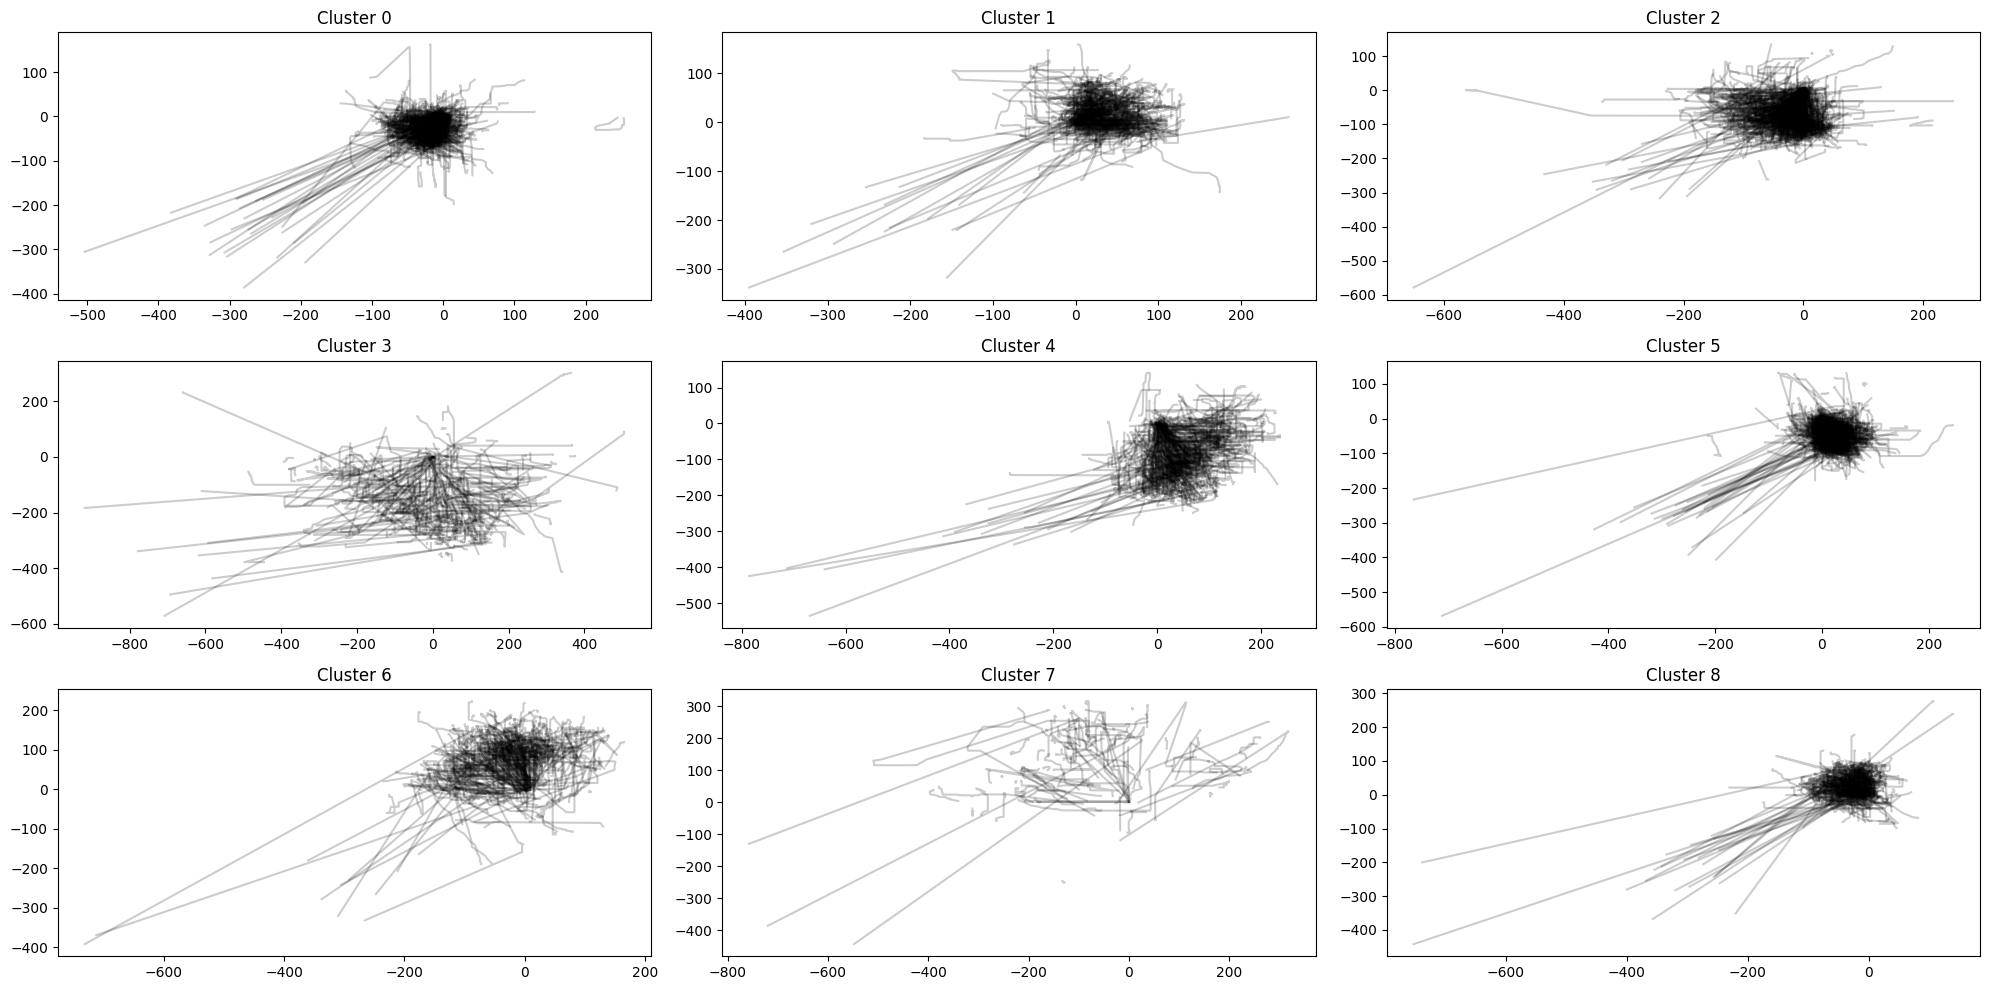

In [33]:
plt.figure(figsize=(20, 10))
for yi in range(9):
    plt.subplot(3, 3, yi + 1)
    for xx in dataset[labels == yi, :, 75:]:
        plt.plot(xx[0], xx[1], "k-", alpha=.2)
    # plt.plot(dataset[labels == yi, 0, 75:].mean(axis=0), dataset[labels == yi, 1, 75:].mean(axis=0), "r-")
    plt.title('Cluster %d' % (yi))


plt.tight_layout()
plt.show()

In [35]:
X_TSNE = TSNE(n_components=2, random_state=42).fit_transform(data_features)

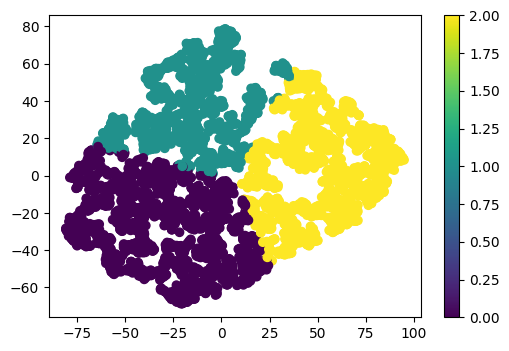

In [ ]:
n_clusters = 3
kmeans_tsne = KMeans(n_clusters=n_clusters)
Y_TSNE = kmeans_tsne.fit_predict(X_TSNE)
plt.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c = Y_TSNE)
plt.colorbar()

In [41]:
ang = data.reach_a

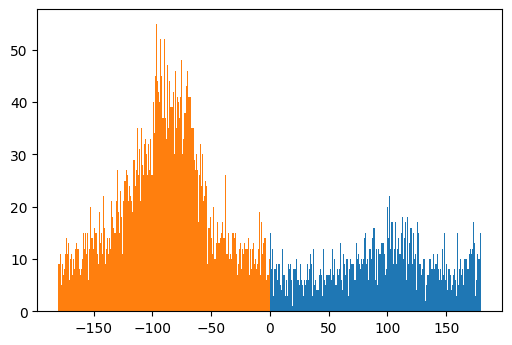

In [48]:
plt.hist(ang[ang > 0], bins=200);
plt.hist(ang[ang < 0], bins=200);

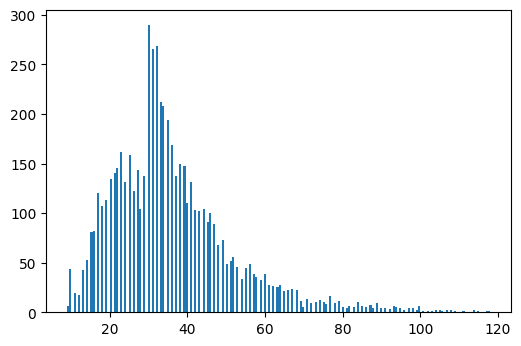

In [53]:
plt.hist(data.reach_duration, bins=200);